# Outperformer - Analyser

In [198]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [265]:
df = pd.DataFrame.from_csv('adj_close.csv')
ndx = pd.DataFrame.from_csv('nasdaq.csv')

### Plot returns of all 105 stocks
#### We can see there is some missing data around June 2014, which causes a spike in the correlation coefficients later

In [200]:
normalized = df.div(df.ix[0], axis=1)
normalized_ndx = ndx.div(ndx.ix[0], axis=1)
normalized.plot(legend=False)

### Calculate 10 day rolling mean correlation coefficients of log returns as a measure of how correlated all stocks in the index are

In [259]:
winsize = 10

In [202]:
log_returns = np.log(df.pct_change() + 1)
log_returns = log_returns[1:] # First row is NaN otherwise
log_returns_ndx = np.log(ndx.pct_change() + 1)
log_returns_ndx = log_returns_ndx[1:] # First row is NaN otherwise

In [203]:
# This calculation will take some time...
# Some calculations leave out the diagonal elements for this calculation (they are always 1.0),
# as they reduce the information amount. For simplicity of calculation we sacrifice this
rolling_corr = log_returns.rolling(window=winsize).corr(pairwise=True)
mean_corr_coeffs = rolling_corr.mean().mean()

### Plotting correlation vs nasdaq (on logarithmic scale)
#### We can see that stress on the market is linked to strong correlation of stocks. The Brexit referendum outcome is also clearly visible

In [261]:
def plotCorrelation(stock, numDays):
    pylab.rcParams['figure.figsize'] = (15,12)
    fig, axes = plt.subplots(nrows=3)
    mean_corr_coeffs[-numDays:].plot(ax=axes[0], sharex=axes[0], ylim=(-0.2,1), style='r-')
    rolling_corr.mean().transpose()[stock][-numDays:].plot(ax=axes[0], sharex=axes[0], style='g-')
    log_returns_ndx.rolling(window=winsize).mean()[-numDays:].plot(ax=axes[1], sharex=axes[0])
    log_returns[stock].rolling(window=winsize).mean()[-numDays:].plot(ax=axes[1], sharex=axes[0])
    normalized_ndx[-numDays:].plot(ax=axes[2], sharex=axes[0])
    normalized[stock][-numDays:].plot(ax=axes[2], sharex=axes[0])

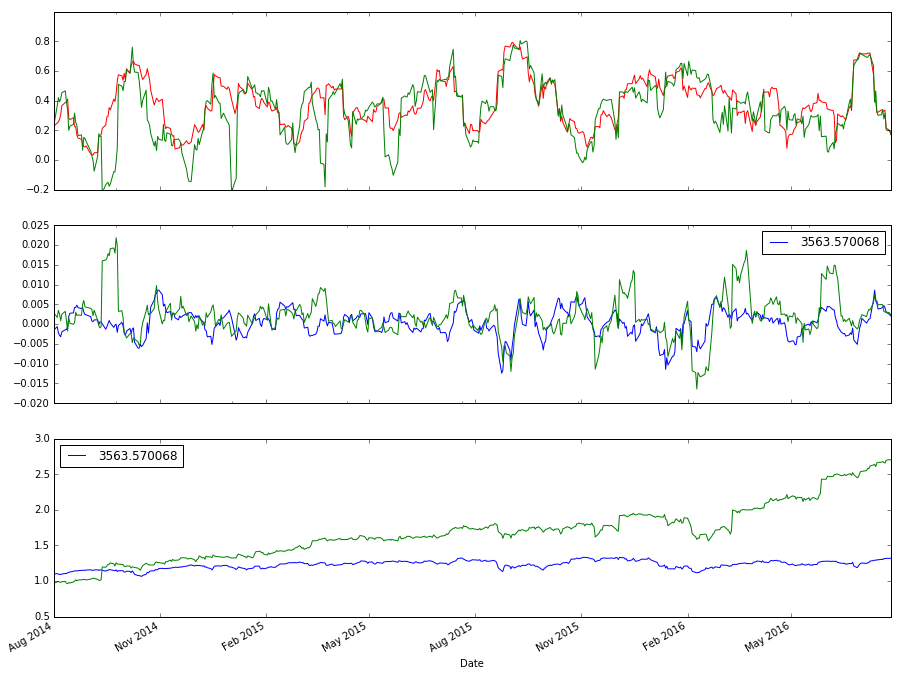

In [262]:
plotCorrelation("ULTA", 500)

### Subset of promising candidates
Outperformers:
ADP!, AVGO!, CHTR!, DLTR?, EA?, FB?, FISV!!!, HSIC!!, INTU!!, ISRG!!, MNST, NTES!, ORLY!, ROST!!, ULTA!!!

Underperformers:
BBBY, DISCA, LBTYA

In [266]:
tickers = ['ADP', 'AVGO', 'CHTR', 'DLTR', 'EA', 'FB', 'FISV', 'HSIC', 'INTU', 'ISRG', 'MNST', 'NTES', 'ORLY', 'ROST', 'ULTA']

## Idea:
## Find outperformers as stock who performed well relative to the benchmark in times of high correlation

In [287]:
def sqr_corr_dep(x):
    # we want to emphasize dependency to correlation by squaring it
    return x[0] * x[1]**2 * 100

num_days = 500
lr = log_returns.rolling(window=winsize).mean()[-num_days:]
corr = mean_corr_coeffs[-num_days:]

vals = []
for stock in tickers:
    df_t = pd.concat([lr[stock], corr], axis=1, keys=[stock, "corr"])
    df_t["corr_weighted_ret"] = df_t.apply(sqr_corr_dep, axis=1)
    vals.append(np.sum(df_t["corr_weighted_ret"]))

df_v = pd.DataFrame({"Tickers": tickers, "Correlation Weighted Returns": vals})
df_v = df_v.sort_values(by="Correlation Weighted Returns", axis=0, ascending=False)
df_v[["Tickers", "Correlation Weighted Returns"]].reset_index(drop=True)

,Tickers,Correlation Weighted Returns
0,ULTA,10.307681
1,ORLY,6.793047
2,NTES,6.462559
3,EA,5.397238
4,FISV,5.396704
5,ISRG,4.058381
6,ROST,3.633119
7,FB,2.753755
8,MNST,2.290810
9,ADP,1.802531


### We can see that ULTA (Ulta Salon, Cosmetics & Fragrance, Inc.) is a strong outperformer over the last 500 days